In [ ]:
#This code implement the advection-diffusion equation with stochastic processes into a QNN.
#The stochastic processes will be introduced by Brownian motion (Wiener process) and White noise

In [2]:
!pip install qiskit-machine-learning

     ---------------------------------------- 0.0/133.4 kB ? eta -:--:--
     -------- ---------------------------- 30.7/133.4 kB 660.6 kB/s eta 0:00:01
     -------------------------------------- 133.4/133.4 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/97.8 kB ? eta -:--:--
   ---------------------------------------- 0.0/97.8 kB ? eta -:--:--
   ---------------------------------------- 0.0/97.8 kB ? eta -:--:--
   ---------------------------------------- 0.0/97.8 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/97.8 kB ? eta -:--:--
   ---------------------------------------- 97.8/97.8 kB 1.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/4.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.2 MB ? eta -:--:--
    --------------------------------------- 0.1/4.2 MB 1.1 MB/s eta 0:00:04
   - -----------------

In [13]:
!pip install --upgrade qiskit-machine-learning

In [3]:
!pip install torch

   ---------------------------------------- 0.0/159.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/159.8 MB 1.3 MB/s eta 0:02:05
   ---------------------------------------- 0.1/159.8 MB 2.1 MB/s eta 0:01:16
   ---------------------------------------- 0.2/159.8 MB 1.5 MB/s eta 0:01:45
   ---------------------------------------- 0.2/159.8 MB 1.3 MB/s eta 0:02:02
   ---------------------------------------- 0.2/159.8 MB 1.3 MB/s eta 0:02:02
   ---------------------------------------- 0.3/159.8 MB 1.2 MB/s eta 0:02:15
   ---------------------------------------- 0.4/159.8 MB 1.2 MB/s eta 0:02:09
   ---------------------------------------- 0.6/159.8 MB 1.6 MB/s eta 0:01:41
   ---------------------------------------- 0.7/159.8 MB 1.8 MB/s eta 0:01:27
   ---------------------------------------- 0.9/159.8 MB 2.0 MB/s eta 0:01:20
   ---------------------------------------- 1.1/159.8 MB 2.1 MB/s eta 0:01:15
   ---------------------------------------- 1.3/159.8 MB 2.3 MB/s eta 0

In [14]:
!pip install --upgrade qiskit

In [ ]:
#code of the QNN

In [27]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import TwoLocal, ZZFeatureMap, RealAmplitudes
from qiskit.circuit import Parameter
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms import VQC
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt

algorithm_globals.random_seed = 42
num_qubits = 2
feature_map = ZZFeatureMap(feature_dimension = num_qubits, reps = 1)
ansatz = RealAmplitudes(num_qubits, reps = 1)
qc = QuantumCircuit(num_qubits)
qc.append(feature_map, range(num_qubits))
qc.append(ansatz, range(num_qubits))

def parity(x):
    return f"{bin(x)}".count("1") % 2

sampler = Aer.get_backend('aer_simulator')
sp = Random.Sampler(rng, dd)
qnn = SamplerQNN(
    circuit=qc,
    interpret=parity,
    output_shape=2,
    sampler=sp
)

model = TorchConnector(qnn)

class QuantumModel(nn.Module):
    def __init__(self):
        super(QuantumModel, self).__init__()
        self.qnn_layer = model

    def forward(self, x):
        return self.qnn_layer(x)

quantum_model = QuantumModel()

# Define a loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(quantum_model.parameters(), lr=0.01)

# Generate data for advection-diffusion equation with stochastic component
c = 1.0  # advection speed
D = 0.1  # diffusion coefficient
sigma = 0.1  # intensity of stochastic term

# Time and space discretization
T = 1.0  # total time
L = 1.0  # length of the domain
nx = 50  # number of spatial points
nt = 50  # number of time points
x = np.linspace(0, L, nx)
t = np.linspace(0, T, nt)
dx = x[1] - x[0]
dt = t[1] - t[0]

# Initial condition
u0 = np.sin(np.pi * x)

# Create the Wiener process
def wiener_process(n, dt):
    return np.cumsum(np.random.normal(0, np.sqrt(dt), size=n))

# Function to solve the advection-diffusion equation
def solve_advection_diffusion(u0, c, D, sigma, x, t, dx, dt):
    u = np.zeros((len(t), len(x)))
    u[0, :] = u0

    for n in range(0, len(t) - 1):
        for i in range(1, len(x) - 1):
            u[n + 1, i] = u[n, i] - c * dt / dx * (u[n, i] - u[n, i - 1]) + \
                          D * dt / dx**2 * (u[n, i + 1] - 2 * u[n, i] + u[n, i - 1]) + \
                          sigma * wiener_process(1, dt)

    return u

# Solve the equation
u = solve_advection_diffusion(u0, c, D, sigma, x, t, dx, dt)

# Normalize data
X_train = torch.tensor(x / np.max(x), dtype=torch.float32).reshape(-1, num_qubits)
y_train = torch.tensor(u[-1, :] / np.max(u), dtype=torch.float32).reshape(-1, 1)

# Training loop
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}: Loss = {loss.item()}')

# Making predictions
with torch.no_grad():
    predictions = model(X_train)

# De-normalize predictions
predictions = predictions.numpy() * np.max(u)

# Plot results
plt.plot(x, u[-1, :], label='True')
plt.plot(x, predictions, label='Predicted', color='red')
plt.xlabel('Space (x)')
plt.ylabel('Concentration (u)')
plt.legend()
plt.show()

NameError: name 'Random' is not defined

In [24]:
from qiskit import Aer
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.algorithms import VQC
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.connectors import TorchConnector

import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt

num_qubits = 2
feature_map = ZZFeatureMap(num_qubits, reps=1) #feature_dimension=
ansatz = RealAmplitudes(num_qubits, reps=1)

qc = QuantumCircuit(num_qubits)
qc.append(feature_map, range(num_qubits))
qc.append(ansatz, range(num_qubits))

# Correctly import Aer and initialize the sampler
sampler = Aer.get_backend('aer_simulator')

# Define the QNN with the correct output_shape and interpret function
qnn = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    output_shape=4,
    sampler=sampler
)

# Initialize the TorchConnector after defining the QNN
model = TorchConnector(qnn)

class QuantumModel(nn.Module):
    def __init__(self):
        super(QuantumModel, self).__init__()
        self.qnn_layer = model

    def forward(self, x):
        return self.qnn_layer(x).squeeze()  # Squeeze to remove the extra dimension

quantum_model = QuantumModel()

# Define a loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(quantum_model.parameters(), lr=0.01)

# Generate data for advection-diffusion equation with stochastic component
# ... (rest of the data generation code remains the same)

# Normalize data
X_train = torch.tensor(x / np.max(x), dtype=torch.float32).reshape(-1, num_qubits)
y_train = torch.tensor(u[-1, :] / np.max(u), dtype=torch.float32).reshape(-1, 1)

# Training loop
epochs = 100
batch_size = 5  # Define a batch size
for epoch in range(epochs):
    for i in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        batch_x = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]
        output = quantum_model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}: Loss = {loss.item()}')

# Making predictions
with torch.no_grad():
    predictions = quantum_model(X_train)

# De-normalize predictions
predictions = predictions.numpy() * np.max(u)

# Plot results
plt.plot(x, u[-1, :], label='True')
plt.plot(x, predictions, label='Predicted', color='red')
plt.xlabel('Space (x)')
plt.ylabel('Concentration (u)')
plt.legend()
plt.show()

No interpret function given, output_shape will be automatically determined as 2^num_qubits.


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [33]:
from qiskit import Aer, QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.connectors import TorchConnector
import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt

# Set up the number of qubits (features)
num_qubits = 2

# Define input and weight parameters
input_params = ParameterVector("input", length=num_qubits)
weight_params = ParameterVector("weight", length=2 * num_qubits)

# Define a quantum circuit
qc = QuantumCircuit(num_qubits)
qc.compose(ZZFeatureMap(feature_dimension=num_qubits, reps=1), inplace=True)
qc.compose(RealAmplitudes(num_qubits, reps=1), inplace=True)
qc.measure_all()

# Create the QNN
sampler = Aer.get_backend('aer_simulator')
qnn = SamplerQNN(
    circuit=qc,
    input_params=input_params,
    weight_params=weight_params,
    sampler=sampler,
    input_gradients=True
)

# Convert QNN to a PyTorch model
model = TorchConnector(qnn)

# Define a simple PyTorch model with the QNN layer
class QuantumModel(nn.Module):
    def __init__(self):
        super(QuantumModel, self).__init__()
        self.qnn_layer = model

    def forward(self, x):
        return self.qnn_layer(x)

# Instantiate the model
quantum_model = QuantumModel()

# Define a loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(quantum_model.parameters(), lr=0.01)

# Generate data for advection-diffusion equation with stochastic component
# Constants
c = 1.0  # advection speed
D = 0.1  # diffusion coefficient
sigma = 0.1  # intensity of stochastic term

# Time and space discretization
T = 1.0  # total time
L = 1.0  # length of the domain
nx = 50  # number of spatial points
nt = 50  # number of time points
x = np.linspace(0, L, nx)
t = np.linspace(0, T, nt)
dx = x[1] - x[0]
dt = t[1] - t[0]

# Initial condition
u0 = np.sin(np.pi * x)

# Create the Wiener process
def wiener_process(n, dt):
    return np.cumsum(np.random.normal(0, np.sqrt(dt), size=n))

# Function to solve the advection-diffusion equation
def solve_advection_diffusion(u0, c, D, sigma, x, t, dx, dt):
    u = np.zeros((len(t), len(x)))
    u[0, :] = u0

    for n in range(0, len(t) - 1):
        for i in range(1, len(x) - 1):
            u[n + 1, i] = u[n, i] - c * dt / dx * (u[n, i] - u[n, i - 1]) + \
                          D * dt / dx**2 * (u[n, i + 1] - 2 * u[n, i] + u[n, i - 1]) + \
                          sigma * wiener_process(1, dt)

    return u

# Solve the equation
u = solve_advection_diffusion(u0, c, D, sigma, x, t, dx, dt)

# Normalize data
X_train = torch.tensor(np.column_stack((x / np.max(x), x / np.max(x))), dtype=torch.float32)
y_train = torch.tensor(u[-1, :] / np.max(u), dtype=torch.float32).reshape(-1, 1)

# Print shapes of input and output data for debugging
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Training loop
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    output = quantum_model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}: Loss = {loss.item()}')

# Making predictions
with torch.no_grad():
    predictions = quantum_model(X_train)

# De-normalize predictions
predictions = predictions.numpy() * np.max(u)

# Plot results
plt.plot(x, u[-1, :], label='True')
plt.plot(x, predictions, label='Predicted', color='red')
plt.xlabel('Space (x)')
plt.ylabel('Concentration (u)')
plt.legend()
plt.show()

ValueError: Input param `input[0]` not present in circuit

In [ ]:
#classical neural network
#given a matrix u for the solutions of a diff eq, and a matrix v = u + noise, the NN must predict u after processing v.

Epoch [10/100], Loss: nan
Epoch [20/100], Loss: nan
Epoch [30/100], Loss: nan
Epoch [40/100], Loss: nan
Epoch [50/100], Loss: nan
Epoch [60/100], Loss: nan
Epoch [70/100], Loss: nan
Epoch [80/100], Loss: nan
Epoch [90/100], Loss: nan
Epoch [100/100], Loss: nan


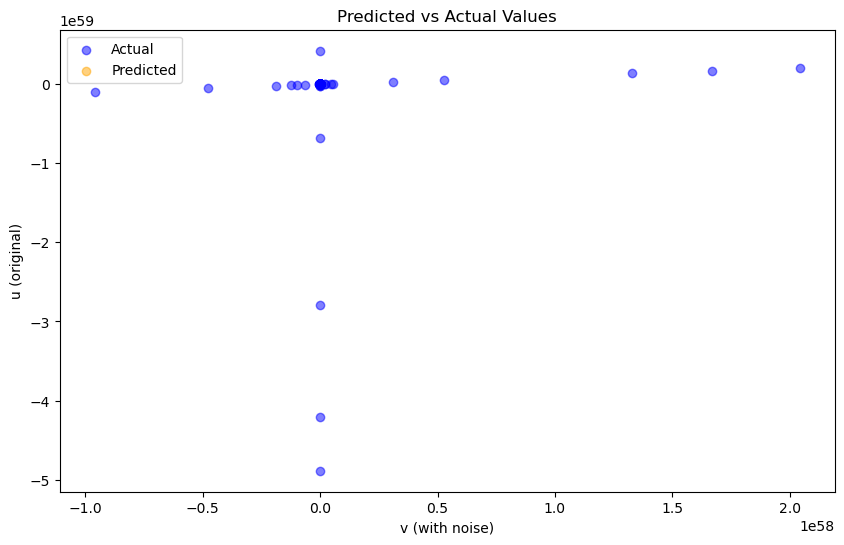

In [43]:
from qiskit import Aer, QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.connectors import TorchConnector
import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt

# Solve the advection-diffusion equation (create the matrix u)*********************************************
# Constants--------------------------------------------
c = 1.0  # advection speed
D = 0.1  # diffusion coefficient
sigma = 0.1  # intensity of stochastic term

# Time and space discretization------------------------
T = 1.0  # total time
L = 1.0  # length of the domain
nx = 50  # number of spatial points
nt = 50  # number of time points
x = np.linspace(0, L, nx)
t = np.linspace(0, T, nt)
dx = x[1] - x[0]
dt = t[1] - t[0]

# Initial condition------------------------------------
u0 = np.sin(np.pi * x)

# Function to solve the advection-diffusion equation---
def solve_advection_diffusion(u0, c, D, sigma, x, t, dx, dt):
    u = np.zeros((len(t), len(x)))
    u[0, :] = u0

    for n in range(0, len(t) - 1):
        for i in range(1, len(x) - 1):
            u[n + 1, i] = u[n, i] - c * dt / dx * (u[n, i] - u[n, i - 1]) + \
                          D * dt / dx**2 * (u[n, i + 1] - 2 * u[n, i] + u[n, i - 1]) 

    return u

# Solve the equation
u = solve_advection_diffusion(u0, c, D, sigma, x, t, dx, dt)

# Create the Wiener process

#return np.cumsum(np.random.normal(0, np.sqrt(dt), size=n))
n = (nx, nt)
v = np.zeros((len(t), len(x)))
samples = np.random.normal(0, np.sqrt(dt), size=n)
for i in range(0, len(t) - 1):
    for j in range(1, len(x) - 1):
        v[i, j] = u[i, j] + samples[i, j]

#Torch doens't support 2D arrays-----
u_flat = u.flatten()
v_flat = v.flatten()

# Create a mask for training (80%) and testing (20%)
mask = np.random.rand(len(u_flat)) < 0.8
u_train, u_test = u_flat[mask], u_flat[~mask]
v_train, v_test = v_flat[mask], v_flat[~mask]

# Convert data to PyTorch tensors
u_train_tensor = torch.tensor(u_train, dtype=torch.float32).unsqueeze(1)
v_train_tensor = torch.tensor(v_train, dtype=torch.float32).unsqueeze(1)
u_test_tensor = torch.tensor(u_test, dtype=torch.float32).unsqueeze(1)
v_test_tensor = torch.tensor(v_test, dtype=torch.float32).unsqueeze(1)

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the network
model = SimpleNN()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(v_train_tensor)
    loss = criterion(outputs, u_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    u_pred = model(v_test_tensor).numpy()

# Visualize the predictions vs actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(v_test, u_test, label='Actual', alpha=0.5, color='blue')
plt.scatter(v_test, u_pred, label='Predicted', alpha=0.5, color='orange')
plt.xlabel('v (with noise)')
plt.ylabel('u (original)')
plt.legend()
plt.title('Predicted vs Actual Values')
plt.show()